In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize
from scipy.spatial.distance import cdist
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.imagenet_utils import decode_predictions 

In [2]:
def load_img(path, input_size):
    # load the test image
    img = image.load_img(path, target_size=input_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [3]:
def generate_masks_conv_output(input_size, last_conv_output, N, s= 8):
    # generate a mask from the feature maps of the last convolutional layer  
    cell_size = np.ceil(np.array(input_size) / s)
    up_size = (s) * cell_size
    masks = np.empty((*input_size, N))
    for i in tqdm(range(N), desc='Generating masks'):
        # extracting the each feature maps
        conv_out = last_conv_output[:,:,i]
        # converting them to binary masks
        conv_out = conv_out > 0.5
        conv_out = conv_out.astype('float32')
        # upsampling the binary masks using bilinear interpolation
        final_resize = resize(conv_out, up_size, order=1, mode='constant', cval=0, anti_aliasing=True)
        masks[:, :, i] = final_resize            
    return masks

In [4]:
def kernel(d, kernel_width):
    # computing the exponential weights for the differences
    return np.sqrt(np.exp(-(d ** 2) / kernel_width ** 2))  

def sim_differences(pred_org, preds):
    # computing the similarity differences
    diff = abs(pred_org-preds)
    weights= kernel(diff,0.25)
    return weights, diff

def normalize(array):
    return (array - array.min()) / (array.max() - array.min() + 1e-13)   

def uniqness_measure(masks_predictions):
    # computing the uniqueness between the feature maps
    sum_all_cdist =(cdist(masks_predictions, masks_predictions)).sum(axis=1)
    sum_all_cdist = normalize(sum_all_cdist)
    return sum_all_cdist

In [5]:
def explain_SIDU(model, inp, N, p1, masks):
    # predicting for the original input image
    pred_org = model.predict(inp)
    # predicting for the masked input image
    masked = inp * masks
    pred = model.predict(masked)
    
    # SIDU explanation
    weights, diff = sim_differences(pred_org, pred)
    interactions = uniqness_measure(pred)
    new_interactions = interactions.reshape(-1, 1)
    diff_interactions = np.multiply(weights, new_interactions)
    
    sal = diff_interactions.T.dot(masks.reshape(N, -1)).reshape(-1, 224, 224)
    sal = sal / N / p1
    return sal, weights, new_interactions, diff_interactions, pred_org

In [6]:
def class_name(idx):
    # decoding an imagenet class index to its name
    return decode_predictions(np.eye(1, 1000, idx))[0][0][1]

In [7]:
# Load the pretrained model for Resnet50 available in Keras.
base_model = ResNet50()
features_model = Model(inputs=base_model.input, outputs=base_model.get_layer('conv5_block3_out').output)

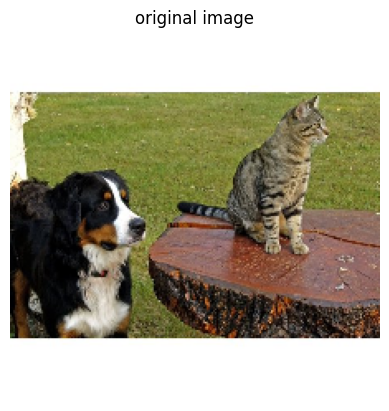

In [8]:
# Let's see the original image
img, x = load_img('images/dogs.png', (224, 224))
plt.imshow(img)
plt.title('original image')
plt.axis('off')
plt.show()

In [9]:
# extract the feature maps of the last convolutional layer of the model
feature_activation_maps = features_model.predict(x)
last_conv_output = np.squeeze(feature_activation_maps)
N = last_conv_output.shape[-1]

# SIDU explanation 
masks = generate_masks_conv_output((224, 224), last_conv_output, N, s= 8)
masks = np.rollaxis(masks, 2, 0)
data = masks.reshape(*masks.shape[:3], 1)
sal, weights, new_interactions, diff_interactions, pred_org = explain_SIDU(base_model, x, N, 0.5, data)

# getting the heatmap for the top predicted class
pred_vec= base_model.predict(x)
class_idx = np.argmax(pred_vec)
heatmap = sal[class_idx]

1/1 [==============================] - 1s 581ms/step


Generating masks: 100%|██████████| 2048/2048 [00:03<00:00, 616.34it/s]


1/1 [==============================] - 0s 63ms/step


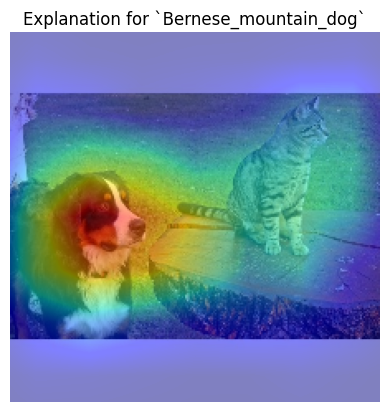

In [10]:
# Let's apply the explanation heatmap on the image to see the areas that are encouraging the top prediction(s).
plt.title(f'Explanation for `{class_name(class_idx)}`')
plt.axis('off')
plt.imshow(img)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.axis('off') 
# plt.colorbar()
plt.show()